# Final Project - Brain Tumor Dataset Classifications / Segmnenation

In this project we use Brain Tumor Dataset, which was mentioned on [Brain Tumor Classification Using Convolutional Neural Netowrk](https://link.springer.com/chapter/10.1007/978-981-10-9035-6_33) [1]. 

Our tasks:
1. To classify brain tumors by kind, which will be elaborated later.
2. Tumors segmentation - our goal is to differ a tumor and the healthy parts of the brain.
3. The last task will be to use the combination of the MRI images of the brain and the corresponding segementation image, to classify the tumors.

In [287]:
# use this if the package is not included in colab
!pip install mat73
!pip install shap

In [288]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import torch
import tqdm.notebook as tq

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import mat73
import pickle

import shap

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [289]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [290]:
# Set the random seed manually for reproducibility.
np.random.seed(1111)
torch.manual_seed(1111)

# Data Arrangments -
In the following code we will collect the data from the '.mat' files we got from [Jun Cheng. (2017). Brain Tumor Dataset (Version 5)](https://doi.org/10.6084/m9.figshare.1512427.v5) [1], which is mentioned in the paper we use as a benchmark.

([direct data link here](https://figshare.com/articles/dataset/brain_tumor_dataset/1512427/5))


We unzipped to the whole data, and zip back together all the .mat files into one big zip file which called BTD.zip.

Through the data extraction, we present few examples. For each example we present two images:



1.   MRI image of the brain (with border around the tumor).
2.   Mask image of the tumor area.

The data contains 3 classes:

0.   [Meningioma tumor](https://en.wikipedia.org/wiki/Meningioma) (708 samples).
1.   [Glioma tumor](https://en.wikipedia.org/wiki/Glioma) (1426 samples).
2.   [Pituitary tumor](https://en.wikipedia.org/wiki/Pituitary) (930 samples).







In [ ]:
# path = '/content/gdrive/My Drive/Colab Notebooks/DNN-Intro-Final/Data/BTD/'
# path = "./data/BTD/" # for local use

# this code is to overcome slow extracting in colab:
zip_path = '/content/gdrive/My\ Drive/Colab\ Notebooks/DNN-Intro-Final/Data/BTD.zip'
!cp {zip_path} .
!mkdir ./our_data
!unzip -q BTD.zip -d ./our_data
!rm BTD.zip
path = "/content/our_data/"

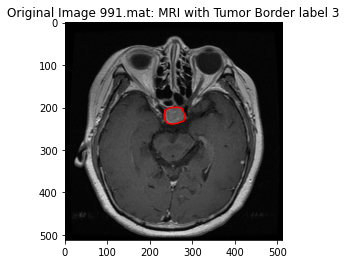

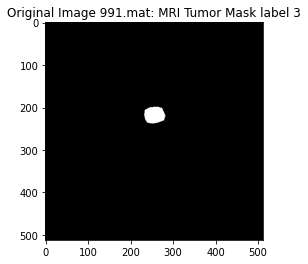

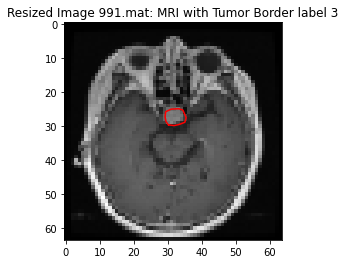

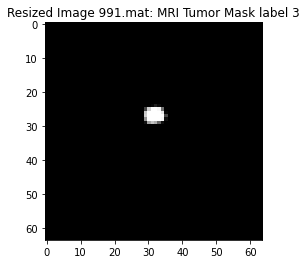

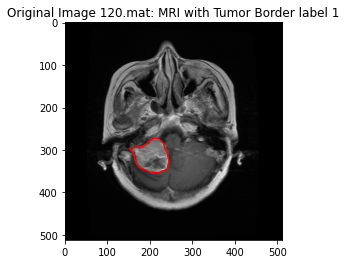

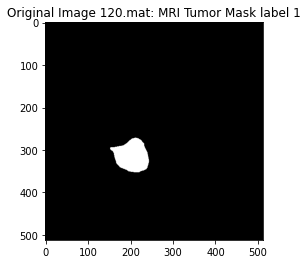

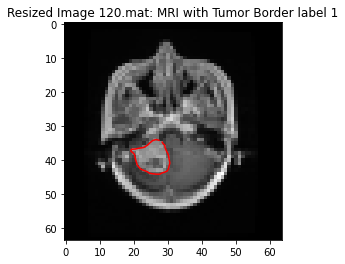

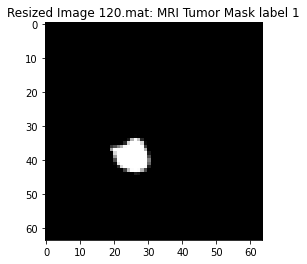

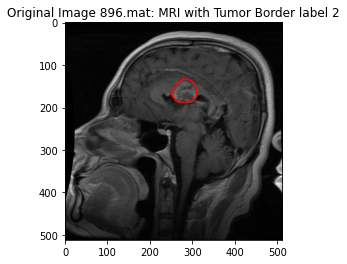

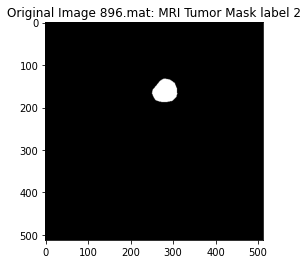

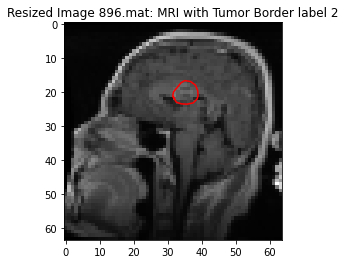

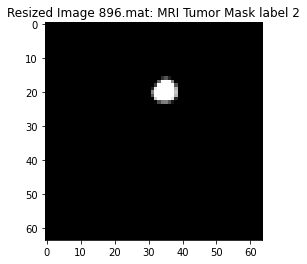

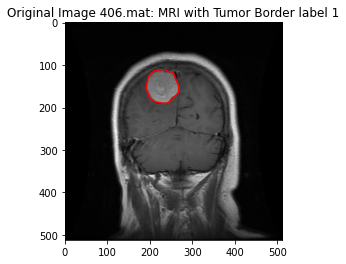

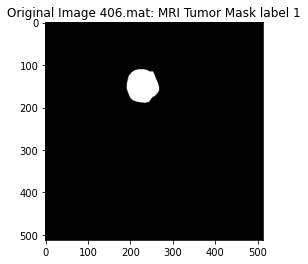

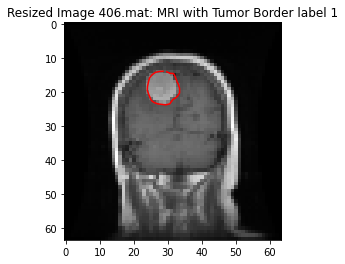

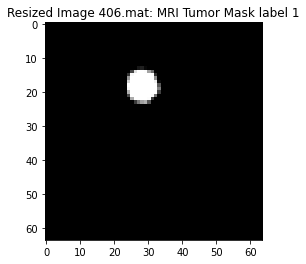

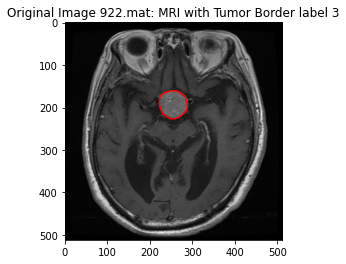

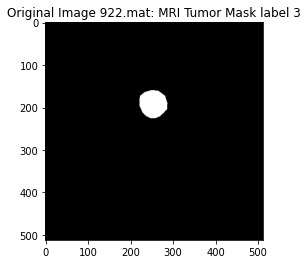

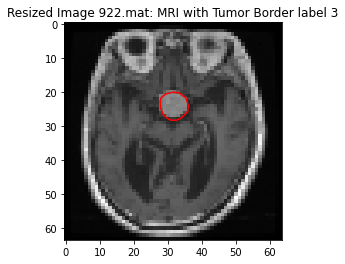

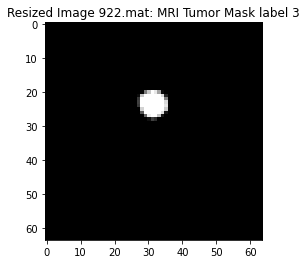

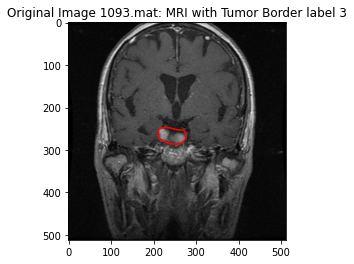

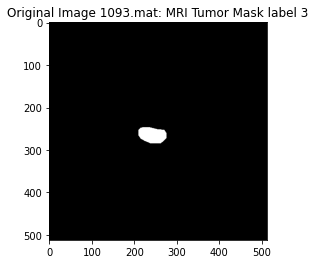

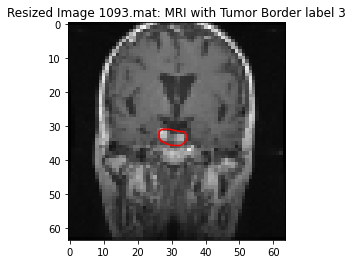

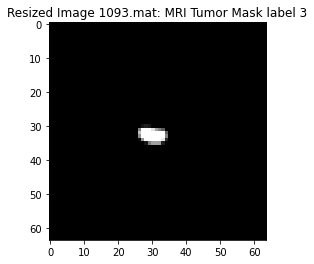


#3064 overall data samples


In [ ]:
# initializing data containers
data_x = []
data_y_label = []
data_y_border = []
data_y_mask = []

for filename in tq.tqdm(os.listdir(path)):
  # for each mat file, extracting relevant information
  mat = mat73.loadmat(f'{path}/{filename}')
  image = mat['cjdata']['image']
  # resizing image to 64x64 for all images:
  image_resized = cv2.resize(image, (64, 64), interpolation=cv2.INTER_AREA)
  # normalizing the data - [0,1]:
  image_resized = image_resized / np.max(image_resized)
  # label:
  label = mat['cjdata']['label']
  # border - only to show the data - list of (x,y) dots:
  border = mat['cjdata']['tumorBorder']
  border_resized = border * 64 / image.shape[0]
  # mask - segmentation image of the tumor:
  mask = mat['cjdata']['tumorMask'].astype(float)
  mask_resized = cv2.resize(mask, (64, 64), interpolation=cv2.INTER_AREA)
  # appending to the containers:
  data_x.append(image_resized)
  data_y_label.append(label)
  data_y_border.append(border_resized)
  data_y_mask.append(mask_resized)

  # print examples once in a while
  if np.random.binomial(size=1, n=1, p=0.001):
    x = [z for i, z in enumerate(border) if i % 2 == 0]
    y = [z for i, z in enumerate(border) if i % 2 != 0]
    plt.imshow(image, cmap='gray')
    plt.plot(x, y, color='r')
    plt.title(f'Original Image {filename}: MRI with Tumor Border label {int(label)}')
    plt.show()
    plt.imshow(mask, cmap='gray')
    plt.title(f'Original Image {filename}: MRI Tumor Mask label {int(label)}')
    plt.show()
    x = [z for i, z in enumerate(border_resized) if i % 2 == 0]
    y = [z for i, z in enumerate(border_resized) if i % 2 != 0]
    plt.imshow(image_resized, cmap='gray')
    plt.plot(x, y, color='r')
    plt.title(f'Resized Image {filename}: MRI with Tumor Border label {int(label)}')
    plt.show()
    plt.imshow(mask_resized, cmap='gray')
    plt.title(f'Resized Image {filename}: MRI Tumor Mask label {int(label)}')
    plt.show()

# transfroming data into tensors
data_x = torch.FloatTensor(data_x)-0.5
data_y_label = np.array(data_y_label) - 1
data_y_label = torch.unsqueeze(torch.Tensor(data_y_label), -1)
data_y_mask = torch.Tensor(data_y_mask)
print(f'#{len(data_x)} overall data samples')

**NOTE:** As you can see, we resized the MRI images and masks to a smaller dimension, because the given dimensions are 256x256 or 512x512 which is too big for processing.

The new dimensions that we will work with are: 64x64 (for mask and MRI image).

We create a shuffle method to shuffle the data with, for the training process.



In [291]:
# Shuffeling the data according to random permutation
def shuffle_data(x, y_label, y_mask):
    reindex = np.random.permutation(len(x))
    return x[reindex], y_label[reindex], y_mask[reindex]

We split the data into train, validation and test sets.

For each class from the 3 classes, we pick 80% for train, 10% for validation and 10% for test. Before spliting the class, we shuffle it to avoid order effects caused by specific order of the data that might have been.



In [ ]:
# dividing the data into equal ratio of classes in each set
train_x, train_y_label, train_y_mask = [], [], []
valid_x, valid_y_label, valid_y_mask = [], [], []
test_x, test_y_label, test_y_mask = [], [], []

train_x_700_img, train_y_label_700_img, train_y_mask_700_img = [], [], []
valid_x_700_img, valid_y_label_700_img, valid_y_mask_700_img = [], [], []
test_x_700_img, test_y_label_700_img, test_y_mask_700_img = [], [], []


for i in range(3):        # running on 0,1,2 classes
    idx = torch.where(data_y_label == i)[0]   # getting indices of specific class
    size = len(idx)
    print(f'class {i} has #{size} elements')
    class_data_x = data_x[idx]
    class_data_y_label = data_y_label[idx]
    class_data_y_mask = data_y_mask[idx]

    # shuffling the data taken from specific class
    class_data_x, class_data_y_label, class_data_y_mask = shuffle_data(class_data_x, 
                                                                       class_data_y_label, 
                                                                       class_data_y_mask)

    # divide the data into train, validation and test (80%, 10%, 10%)
    train_x.append(class_data_x[:(size // 10) * 8])
    train_y_label.append(class_data_y_label[:(size // 10) * 8])
    train_y_mask.append(class_data_y_mask[:(size // 10) * 8])

    valid_x.append(class_data_x[(size // 10) * 8:(size // 10) * 9])
    valid_y_label.append(class_data_y_label[(size // 10) * 8:(size // 10) * 9])
    valid_y_mask.append(class_data_y_mask[(size // 10) * 8:(size // 10) * 9])

    test_x.append(class_data_x[(size // 10) * 9:])
    test_y_label.append(class_data_y_label[(size // 10) * 9:])
    test_y_mask.append(class_data_y_mask[(size // 10) * 9:])

    # divide the data into train, validation and test (80%, 10%, 10%) 700 images from each class
    size2 = 700
    train_x_700_img.append(class_data_x[:(size2 // 10) * 8])
    train_y_label_700_img.append(class_data_y_label[:(size2 // 10) * 8])
    train_y_mask_700_img.append(class_data_y_mask[:(size2 // 10) * 8])

    valid_x_700_img.append(class_data_x[(size2 // 10) * 8:(size2 // 10) * 9])
    valid_y_label_700_img.append(class_data_y_label[(size2 // 10) * 8:(size2 // 10) * 9])
    valid_y_mask_700_img.append(class_data_y_mask[(size2 // 10) * 8:(size2 // 10) * 9])

    test_x_700_img.append(class_data_x[(size2 // 10) * 9: size2])
    test_y_label_700_img.append(class_data_y_label[(size2 // 10) * 9: size2])
    test_y_mask_700_img.append(class_data_y_mask[(size2 // 10) * 9: size2])

train_x, train_y_label, train_y_mask = torch.cat(train_x, dim=0).unsqueeze(-3), torch.cat(train_y_label, dim=0).squeeze(), torch.cat(train_y_mask, dim=0)
valid_x, valid_y_label, valid_y_mask = torch.cat(valid_x, dim=0).unsqueeze(-3), torch.cat(valid_y_label, dim=0).squeeze(), torch.cat(valid_y_mask, dim=0)
test_x, test_y_label, test_y_mask = torch.cat(test_x, dim=0).unsqueeze(-3), torch.cat(test_y_label, dim=0).squeeze(), torch.cat(test_y_mask, dim=0)

train_x_700_img, train_y_label_700_img, train_y_mask_700_img = torch.cat(train_x_700_img, dim=0).unsqueeze(-3), torch.cat(train_y_label_700_img, dim=0).squeeze(), torch.cat(train_y_mask_700_img, dim=0)
valid_x_700_img, valid_y_label_700_img, valid_y_mask_700_img = torch.cat(valid_x_700_img, dim=0).unsqueeze(-3), torch.cat(valid_y_label_700_img, dim=0).squeeze(), torch.cat(valid_y_mask_700_img, dim=0)
test_x_700_img, test_y_label_700_img, test_y_mask_700_img = torch.cat(test_x_700_img, dim=0).unsqueeze(-3), torch.cat(test_y_label_700_img, dim=0).squeeze(), torch.cat(test_y_mask_700_img, dim=0)

print("\nAll images for each class")
print("train length: ", len(train_x), "(", train_x.shape, ")")
print("valid length: ", len(valid_x), "(", valid_x.shape, ")")
print("test length: ", len(test_x), "(", test_x.shape, ")")

print("\n700 images for each class")
print("train length: ", len(train_x_700_img), "(", train_x_700_img.shape, ")")
print("valid length: ", len(valid_x_700_img), "(", valid_x_700_img.shape, ")")
print("test length: ", len(test_x_700_img), "(", test_x_700_img.shape, ")")


class 0 has #708 elements
class 1 has #1426 elements
class 2 has #930 elements

All images for each class
train length:  2440 ( torch.Size([2440, 1, 64, 64]) )
valid length:  305 ( torch.Size([305, 1, 64, 64]) )
test length:  319 ( torch.Size([319, 1, 64, 64]) )

700 images for each class
train length:  1680 ( torch.Size([1680, 1, 64, 64]) )
valid length:  210 ( torch.Size([210, 1, 64, 64]) )
test length:  210 ( torch.Size([210, 1, 64, 64]) )


# Classification Model -

**The input of the model:** MRI brain image - gray scale image with size of 64x64.

**The output of the model:** one value from the set {0,1,2} which represents the tumor class of the image. 


Creating a model based on Convolutional Layers:



*The model with our best model parameters
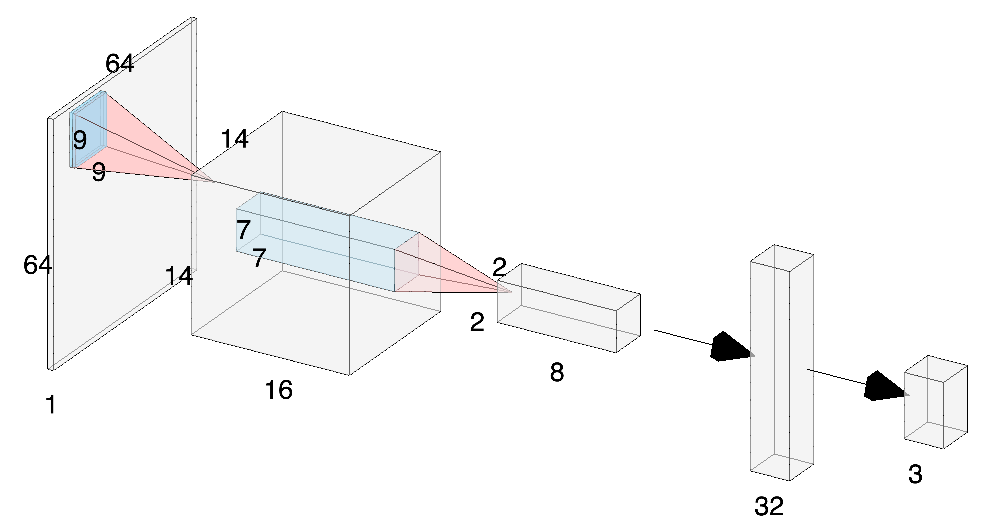

Each block represents the data after each operation. The operations are the connections between two blocks (red-blue is the convolutional filters, and the black arrow is a fully connected layer).

The model contain the following layers:
- Cnn layer (channels_out = 16 ,kernel size = 9)
- BatchNorm2d layer
- ReLU activation
- maxpooling (4,4)
* Dropout2d (p)

- Cnn layer (channels_out = 8 ,kernel size = 7)
- BatchNorm2d layer
- ReLU activation
- maxpooling (4,4)
* Dropout2d (p)


- FC layel (input = 32, output = 3)


*We get the best results for p=0 (without dropout).

Now lets build the model,

In [292]:
class Model(nn.Module):
    def __init__(self, n=16, p=0, in_channels=1):
        super(Model, self).__init__()
        self.cnn_layers = nn.Sequential(
            # Defining a 2D convolution layer
            nn.Conv2d(in_channels=in_channels, 
                      out_channels=n, 
                      kernel_size=9, 
                      stride=1, 
                      padding=0),
            nn.BatchNorm2d(num_features=n),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),

            nn.Dropout2d(p = p),

            # Defining second 2D convolution layer
            nn.Conv2d(in_channels=n, 
                      out_channels=n//2, 
                      kernel_size=7, 
                      stride=1, 
                      padding=0),
            nn.BatchNorm2d(num_features=n//2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, 
                         stride=4),
            
            nn.Dropout2d(p = p),


        )

        self.linear_layers = nn.Sequential(
            nn.Linear(32, 3),
            
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x



## Training Loop Creation - #

Setting up the training loop.
Validation check is done very epoch.

In [293]:
def train(model, num_epochs=5, batch_size=64, learning_rate=1e-3, weight_decay=1e-5, img_700=False):
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    iters_train = 0
    iters_valid = 0

    if img_700:
        train_x_2, train_y_label_2, train_y_mask_2= train_x_700_img.cuda(), train_y_label_700_img.cuda(), train_y_mask_700_img.cuda()
        valid_x_2, valid_y_label_2 = valid_x_700_img.cuda(), valid_y_label_700_img.cuda()
    else:
        train_x_2, train_y_label_2, train_y_mask_2= train_x.cuda(), train_y_label.cuda(), train_y_mask.cuda()
        valid_x_2, valid_y_label_2 = valid_x.cuda(), valid_y_label.cuda()
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    for epoch in range(num_epochs):
        tr_x, tr_y_label, tr_y_mask = shuffle_data(train_x_2, train_y_label_2, train_y_mask_2)   # shuffle the data before train
        epoch_loss = []
        epoch_acc = []
        for i in range(0, len(tr_x), batch_size):                                          # iterate over each minibatch
            # minibatch that we are working with:
            x = tr_x[i:(i + batch_size)]
            y_label = tr_y_label[i:(i + batch_size)]
            y_mask = tr_y_mask[i:(i + batch_size)]
            # since len(train_x) does not divide batch_size evenly, we will skip over
            # the "last" minibatch
            if np.shape(x)[0] != batch_size:
                continue

            optimizer.zero_grad()
            model_out = model(x)
            loss = criterion(model_out, y_label.type(torch.cuda.LongTensor))

            iters_train += 1
            epoch_loss.append(loss)                                                         # train loss append
            probs = torch.softmax(model_out, dim=-1)

            ans = probs.argmax(dim=-1)
            epoch_acc.append(torch.sum( probs.argmax(dim=-1) == y_label) / batch_size)        # train accuracy append
            loss.backward()
            optimizer.step()

        # validation check:
        iters_valid += 1
        with torch.no_grad():
            model_out = model(valid_x_2)
        valid_losses.append(criterion(model_out, valid_y_label_2.type(torch.cuda.LongTensor)))
        probs = torch.softmax(model_out, dim=-1)
        valid_accuracies.append(torch.sum( probs.argmax(dim=-1) == valid_y_label_2 ) / len(valid_x_2))

        train_losses.extend(epoch_loss)
        train_accuracies.extend(epoch_acc)

        epoch_loss = torch.FloatTensor(epoch_loss)
        epoch_acc = torch.FloatTensor(epoch_acc)
        print('Epoch:{}, Mean Train Loss:{:.4f}, Mean Train Accuracy:{:.4f}, '\
              'Valid Loss:{:.4f}, Valid Accuracy:{:.4f}'  \
              .format(epoch+1, torch.mean(epoch_loss), torch.mean(epoch_acc), valid_losses[-1], valid_accuracies[-1]))
    return iters_train, train_losses, train_accuracies, iters_valid, valid_losses, valid_accuracies


In [294]:
def plot_learning_curve(iters_train, train_losses, train_accs, iters_valid, valid_losses, valid_accs):
    """
    Plot the learning curve.
    """
    d = iters_train // iters_valid

    plt.title("Learning Curve: Loss per Iteration")
    plt.plot(range(iters_train), train_losses, label="Train")
    plt.plot(range(d, iters_train+1, d), valid_losses, label="Valid")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.grid()
    plt.show()

    plt.title("Learning Curve: Accuracy per Iteration")
    plt.plot(range(iters_train), train_accs, label="Train")
    plt.plot(range(d, iters_train+1, d), valid_accs, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.legend(loc='best')
    plt.show()

**Training Process Note:**

The accuracy of the model is determine with respect to the true class .

**Loss:**

$$ \
\mathcal{l(\mathbf{X_n})}=-t_n \log{(y_n)} + (1-t_n) \log{(1-y_n)}
\\
 $$
 
 $X_n$ - MRI brain image
 
 $t_n$ - true label
 
 $y_n$ - model's prediction


**Cost:**

$$ \mathcal{L}(X)=\frac{1}{N}\sum_{n=1}^{N}\mathcal{l_n(X_n)}
\\
 $$

$N$ - number of MRI brain image in one bach

**Decision rule:** 

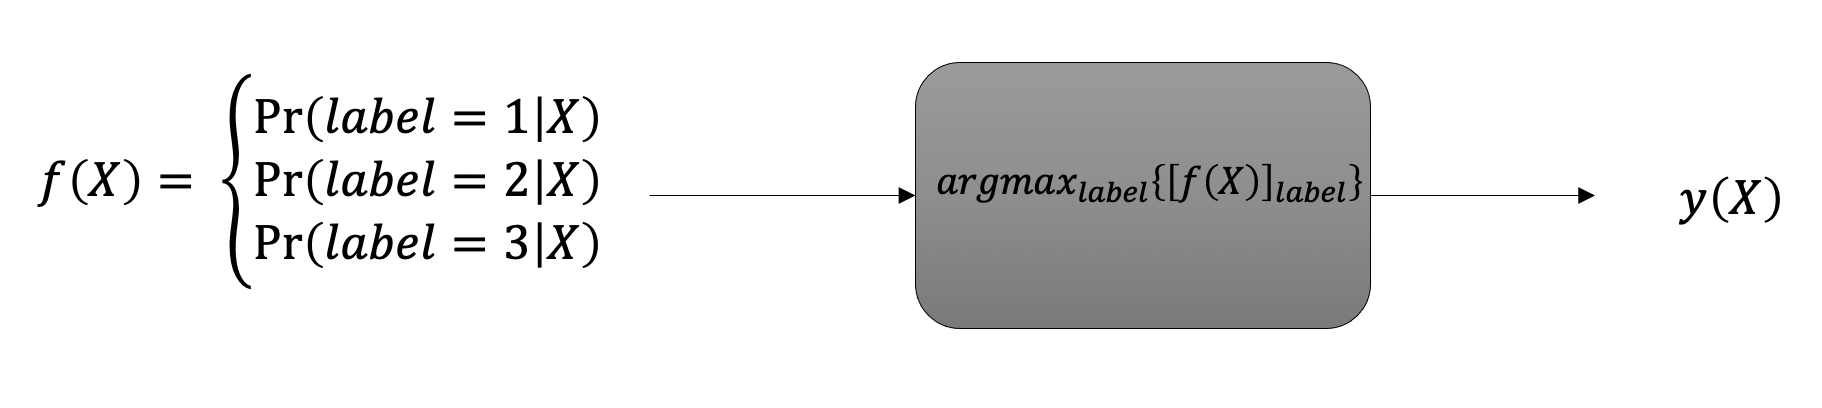

$X$ - MRI brain image

$f(X)$ - the output of the DNN model

$y$ - the esstimation label of the input $X$ 

## Running the Model -

### Training the Model

Model creation, training and plotting results for train and validation set.

In the following section we will search for the optimal hyperparameters - rate of dropout, weight decay value (L2 regularization) and learning rate.

We want to take the best model in terms of validation accuracy.

#### Hyperparameter Sweep

In [ ]:
p_list = [0.0, 0.3]
lr_list = [5e-4, 1e-3, 5e-3]
wd_list = [0,1e-5, 1e-3]

max_valid_acc = 0 
for p in p_list:
    for lr in lr_list:
        for wd in wd_list:
            model=Model(p=p).cuda()
            #print(Model)
            print('#######################################')
            print('   p = {:.2} | lr = {} | wd = {}   '.format(p,lr,wd))
            print('#######################################')
            train_info = train(model=model,
                            num_epochs=30, 
                            batch_size=64, 
                            learning_rate=lr, 
                            weight_decay=wd, img_700=True)
            _, _, _, _, _, valid_accs = train_info
            if max_valid_acc < max(valid_accs):
                max_valid_acc = max(valid_accs)
                epoch = np.argmax(np.array(valid_accs))
                res={'p':p, 'lr':lr, 'wd':wd, 'epoch':epoch, 'max valid':float(max_valid_acc)}
                path='/content/gdrive/My Drive/Colab Notebooks/DNN-Intro-Final/learning curves/train_info.p'
                pickle.dump( (train_info,res), open( path, "wb" ) )
            

            
#plot_learning_curve(*train_info)

#######################################
   p = 0.0 | lr = 0.0005 | wd = 0   
#######################################
Epoch:1, Mean Train Loss:0.9008, Mean Train Accuracy:0.6028, Valid Loss:0.7430, Valid Accuracy:0.7286
Epoch:2, Mean Train Loss:0.6851, Mean Train Accuracy:0.7428, Valid Loss:0.6527, Valid Accuracy:0.7476
Epoch:3, Mean Train Loss:0.5924, Mean Train Accuracy:0.7957, Valid Loss:0.6035, Valid Accuracy:0.7667
Epoch:4, Mean Train Loss:0.5330, Mean Train Accuracy:0.8347, Valid Loss:0.5554, Valid Accuracy:0.7905
Epoch:5, Mean Train Loss:0.4826, Mean Train Accuracy:0.8636, Valid Loss:0.5263, Valid Accuracy:0.8095
Epoch:6, Mean Train Loss:0.4437, Mean Train Accuracy:0.8810, Valid Loss:0.5030, Valid Accuracy:0.8095
Epoch:7, Mean Train Loss:0.4048, Mean Train Accuracy:0.8912, Valid Loss:0.4652, Valid Accuracy:0.8476
Epoch:8, Mean Train Loss:0.3671, Mean Train Accuracy:0.9159, Valid Loss:0.4342, Valid Accuracy:0.8619
Epoch:9, Mean Train Loss:0.3337, Mean Train Accuracy:0.9207, Valid 

Now we will plot the learning curves with the hyperparameters that gave the best valid accuracy.

the best hyperparameters:

`{'p': 0.0, 'lr': 0.005, 'wd': 1e-5}`


####Training The Best Model

We will train again the best model,

In [ ]:
#run of the model with the best hyperparameter
p = 0.
lr = 0.005
wd = 1e-5

model=Model(p=p).cuda()
#print(Model)
print('#######################################')
print('   p = {:.2} | lr = {} | wd = {}   '.format(p,lr,wd))
print('#######################################')
train_info = train(model=model,
                    num_epochs=30, 
                    batch_size=64, 
                    learning_rate=lr, 
                    weight_decay=wd, img_700=True)

#######################################
   p = 0.0 | lr = 0.005 | wd = 1e-05   
#######################################
Epoch:1, Mean Train Loss:0.7924, Mean Train Accuracy:0.6629, Valid Loss:0.6286, Valid Accuracy:0.7048
Epoch:2, Mean Train Loss:0.5545, Mean Train Accuracy:0.7788, Valid Loss:0.5145, Valid Accuracy:0.7476
Epoch:3, Mean Train Loss:0.4623, Mean Train Accuracy:0.8137, Valid Loss:0.4963, Valid Accuracy:0.7429
Epoch:4, Mean Train Loss:0.3744, Mean Train Accuracy:0.8600, Valid Loss:0.4191, Valid Accuracy:0.8381
Epoch:5, Mean Train Loss:0.2904, Mean Train Accuracy:0.9020, Valid Loss:0.3973, Valid Accuracy:0.8333
Epoch:6, Mean Train Loss:0.2425, Mean Train Accuracy:0.9171, Valid Loss:0.3884, Valid Accuracy:0.8381
Epoch:7, Mean Train Loss:0.2019, Mean Train Accuracy:0.9357, Valid Loss:0.4226, Valid Accuracy:0.7857
Epoch:8, Mean Train Loss:0.2021, Mean Train Accuracy:0.9369, Valid Loss:0.3135, Valid Accuracy:0.8667
Epoch:9, Mean Train Loss:0.1361, Mean Train Accuracy:0.9688, Val


#############################################
#         training curves                   #
#############################################



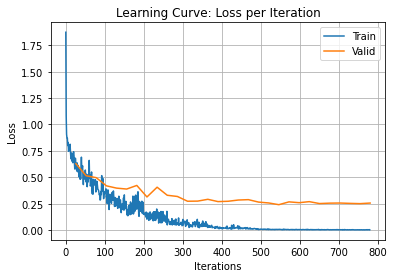

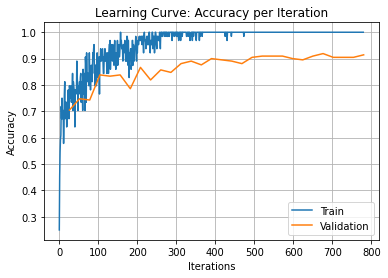

In [ ]:
print('\n#############################################')
print('#         training curves                   #')
print('#############################################\n')
plot_learning_curve(*train_info)

In [ ]:
#save or load the model 

path='/content/gdrive/My Drive/Colab Notebooks/DNN-Intro-Final/model/classification.pt' 

# #save model

#torch.save(model, path) 

In [334]:
#load model
path='/content/gdrive/My Drive/Colab Notebooks/DNN-Intro-Final/model/classification.pt' 

model = torch.load(path)


#testing the model performence

model.eval()
small_subset = train_x_700_img.cuda()

model_out = model(small_subset)
probs = torch.softmax(model_out, dim=-1)
accuracy = torch.sum( probs.argmax(dim=-1) == train_y_label_700_img.cuda() ) / len(small_subset)
print(float(accuracy))

1.0


**The training and validation accuracies:** 

**From the paper:**  98.51% and 84.19% , respectively

**Our result:** 100% and 91.43% , respectively

The training set is almost identical in the accuracy percentages. In addition, the validation set has better accuracy than the paper, i.e. we reduced the generalization error of the model.

### Test Accuracy Check

In [335]:
def estimate_accuracy(model, data_x, data_y, batch_size=5000):
    """
    Estimate the accuracy of the model on the data.
    """
    correct = 0
    N = 0
    for i in range(0, data_x.shape[0], batch_size):
        # get a batch of data
        x = data_x[i:(i + batch_size)]
        y_label = data_y[i:(i + batch_size)]
        
        # forward pass prediction
        with torch.no_grad():
            out = model(x)
        pred = torch.argmax(out, axis=-1)
        correct += torch.sum(pred == y_label)
        N += data_x.shape[0]
    
    return np.float(correct / N)


Evaluating the test set accuracy,

In [336]:
test_acc = estimate_accuracy(model, test_x_700_img.cuda(), test_y_label_700_img.cuda(), batch_size=2000)
print("Test set accuracy: {:.2%}".format(float(test_acc)))

Test set accuracy: 90.48%


As we can see, the test accuracy is pretty much alike the validation, thus we can conclude that our model learned well the data.

##**Features Importance**

We want to break down how the model works for an individual prediction.

SHAP Values (an acronym from SHapley Additive exPlanations) break down a prediction to show the impact of each feature on the class prediction. Positive SHAP values, represent a feature that contributes to a right prediction, for a specific class. (i.e. for class 0, positive values will rise the probability of this specific input, to match class 0). Negative SHAP values, are the oposite, they represent a feature that discriminates the input, from the sepcific class. 

The calculating of SHAP values is being done for each feature - the model with this feature, and the model without it, the only thing that changes is the set of features included in the model. From this test we can determine the importance of a specific feature for the model.

First to calculate it, we need the Marginal Contribution of a feature. We use the model with the feature and subtruct it with the model included the feature. Than we do this calculation for every combination of features we have with that specific feature we want to calculate the SHAP value. Now we need to weight all of those subtraction (which are the marginal contribution of the specific feature). The weighting is done by calculating the number of combinations for those features that are being used in the model and the total feature. The weights will sum to 1 eventually.

Warpping it all up and we will get the following equation:

$SHAP_{feature}(x)=\sum_{set:feature\in set}[{|set|}\times \binom F {|set|}]^{-1}[Predict_{set}(x)-Predict_{set \setminus feature}(x)]$

When F is the number of total features to the model, and |set| is the number of features currently that being used in the model. For each set we will calcualte the marginal contribution - and their are $2^{F}$ models to test for a single input.

More information can be found at [A Unified Approach to Interpreting Model Predictions paper](https://papers.nips.cc/paper/2017/file/8a20a8621978632d76c43dfd28b67767-Paper.pdf) [2] and at [SHAP Values Explained Exactly How You Wished Someone Explained to You](https://towardsdatascience.com/shap-explained-the-way-i-wish-someone-explained-it-to-me-ab81cc69ef30) [3].



Meningioma tumor MRI Image - Model Prediction is Meningioma tumor



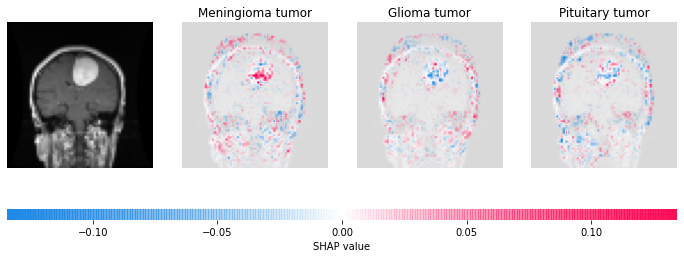


Pituitary tumor MRI Image - Model Prediction is Pituitary tumor



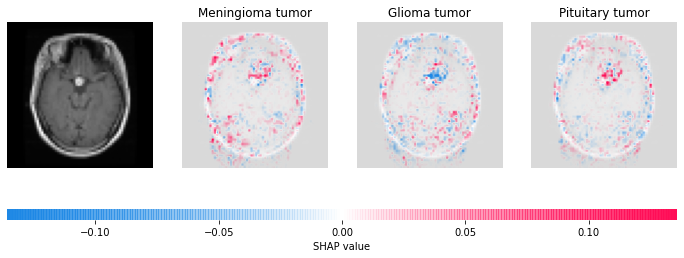

In [332]:
# explain how the input to the 7th layer of the model explains the top two classes
tr_x, tr_y_label, tr_y_mask = shuffle_data(train_x_700_img, train_y_label_700_img, train_y_mask_700_img)   # shuffle the data before train   

n=2

to_explain = tr_x[0:n]

# Class names
class_names={0:'Meningioma tumor', 1:'Glioma tumor', 2:'Pituitary tumor'}

e = shap.GradientExplainer(model.cpu(), to_explain, session=None, batch_size=50, local_smoothing=0)

shap_values,indexes = e.shap_values(to_explain, ranked_outputs=3)

# get the names for the classes
indexes_list=[['Meningioma tumor','Glioma tumor','Pituitary tumor']]
# plot the explanations
for i in range(n):          
    true = tr_y_label[i]
    prediction = torch.argmax(model(to_explain[i].unsqueeze(dim=0).detach()), axis=-1)
    print("\n{} MRI Image - Model Prediction is {}\n".format(class_names[int(true)], class_names[int(prediction)]))
    shap.image_plot(list(np.array(shap_values)[:,i:i+1,0]), to_explain.numpy()[i:i+1,0,:,:], indexes_list)



Predictions for two input images are explained in the plot above. Red pixels represent positive SHAP values that increase the probability of the class, while blue pixels represent negative SHAP values the reduce the probability of the class.

Large (in absoulute) SHAP values can tell us what the model used to classify or discriminate an input to a specific class. We can see that a lot of non-zero SHAP values are around the head frame - which intuitivly won't help us classify or discriminate a brain tumor from MRI scan. 

Because our data contains different images from various angles, the model needs to differ each angle from the other, thus we can infer that large SHAP values (in absolute) exists in the edges of the MRI scan to determine which position the image is.

In addition, we can see that inside the head frame, there are more large positive and negative SHAP values, to determine the class of the tumor.

#**Segmentation Model -**

We will create segmentation model to detect the tumor in the MRI brain image.

**The input of the model:** MRI brain image - gray scale image with size of 64x64.

**The output of the model:** binary image (matrix) with size of 64x64 where each pixel contain '1' if the model detect tumor in this pixel.

*each pixel in the output it's binary clasification problem.

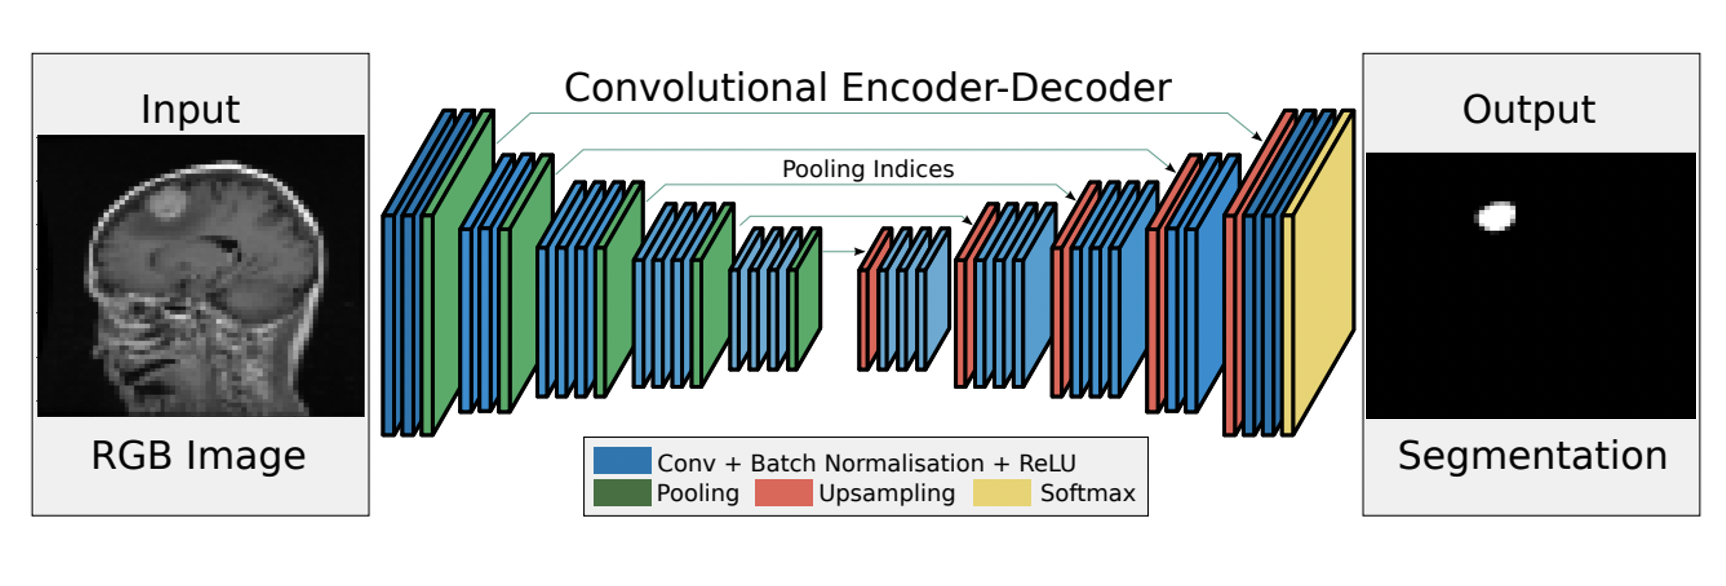

*Taken from: [SegNet: A Deep Convolutional
Encoder-Decoder Architecture for Image
Segmentation](https://arxiv.org/pdf/1511.00561.pdf) [4]

## Creating and Training the model

Creating The model based encoder and decoder.

In [298]:
class encoder(nn.Module):
    '''
        Encoder for the Segmentation network
    '''

    def __init__(self, batchNorm_momentum):
        super(encoder, self).__init__()

        self.main = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1, dilation=3, bias=False),
            nn.BatchNorm2d(64, momentum=batchNorm_momentum),
            nn.ReLU(True),
            nn.Dropout2d(p=0.),

            nn.Conv2d(64, 128, 4, 2, 1, dilation=2, bias=False),
            nn.BatchNorm2d(128, momentum=batchNorm_momentum),
            nn.ReLU(True),
            nn.Dropout2d(p=0.),

            nn.Conv2d(128, 256, 4, 2, 1, dilation=2, bias=False),
            nn.BatchNorm2d(256, momentum=batchNorm_momentum),
            nn.ReLU(True),

        )

    def forward(self, input):
        output = self.main(input)
        return output

class decoder(nn.Module):
    '''
        Decoder for the Segmentation Network
    '''

    def __init__(self, batchNorm_momentum=0.1, num_classes=1):
        super(decoder, self).__init__()
        self.main = nn.Sequential(

            nn.ConvTranspose2d(256, 128, 4, 2, 1, dilation=2, bias=False),
            nn.BatchNorm2d(128, momentum=batchNorm_momentum),
            nn.Dropout2d(),
            nn.ReLU(True),
            nn.Dropout2d(p=0.),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, dilation=2, bias=False),
            nn.BatchNorm2d(64, momentum=batchNorm_momentum),
            nn.ReLU(True),
            nn.Dropout2d(p=0.),

            nn.ConvTranspose2d(64, num_classes, 4, 2, 1, dilation=3, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)
        return output



class SegNet(nn.Module):
    '''
        Segnet network
    '''

    def __init__(self, batchNorm_momentum=0.1, num_classes=1):
        super(SegNet, self).__init__()
        self.encoder = encoder(batchNorm_momentum)
        self.decoder = decoder(batchNorm_momentum, num_classes)

    def forward(self, x):
        latent = self.encoder(x)
        output = self.decoder(latent)
        return output

In [299]:
def out_pred(out):
    avgpool = nn.AvgPool2d(3, stride=1, padding=1)
    out = (out > 0.5).type(torch.cuda.FloatTensor).view(-1,64,64)
    return avgpool(out)


def acc_tpn(out,target):
    """Returns the accuracy of true positive and true negative, after smoothing the output"""
    target = target.squeeze()
    out = out.squeeze()
    # smoothing output to get averaged result:
    out = out_pred(out)
    out = (out > 0.5).type(torch.cuda.FloatTensor)
    if target[target == 1].nelement() == 0:
        true_positive == 1
    else:
        num_pos_targets = target[target == 1].nelement()
        sum_pos_pred = torch.sum(out[target==1])
        true_positive = sum_pos_pred / num_pos_targets

    if target[target==0].nelement() == 0:
        true_negative = 1
    else:
        num_neg_targets = target[target == 0].nelement()
        sum_neg_pred = torch.sum(1 - out[target==0])
        true_negative = sum_neg_pred / num_neg_targets

    return float(true_positive), float(true_negative)


def weighted_bce(model_out, y_label, weighted=True):
    if weighted:
        n_ones = y_label.mean()
        criterion = nn.BCELoss(reduction='none')
        loss = criterion(model_out.squeeze(1).view(-1), y_label.view(-1))   # loss is binary cross entropy for all pixels in the samples
        weight = torch.tensor([n_ones*4, 1-n_ones])
        weight_ = weight[y_label.data.view(-1).long()].view_as(y_label.view(-1)).cuda()
        loss_class_weighted = loss * weight_
        loss_class_weighted = loss_class_weighted.mean()
        return loss_class_weighted
    else:
        criterion = nn.BCELoss()
        return criterion(mode_out.squeeze(1).view(-1), y_label.view(-1))    # loss is binary cross entropy for all pixels in the samples


def train_gen(model, num_epochs=5, batch_size=64, learning_rate=1e-3, weight_decay=1e-5, train_x=train_x, train_y_label=train_y_label):
    train_losses = []
    train_tp = []
    train_tn = []

    valid_losses = []
    valid_tp = []
    valid_tn = []

    valid_conf_mats = []

    iters_train = 0
    iters_valid = 0

    criterion = nn.BCELoss()#nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    for epoch in range(num_epochs):
        tr_x, _, tr_y_label = shuffle_data(train_x, train_y_label, train_y_mask)   # shuffle the data before train
        tr_x = tr_x.cuda()
        tr_y_label = tr_y_label.cuda()
        tr_y_label = tr_y_label>0.5
        epoch_loss = []
        epoch_train_tp = []
        epoch_train_tn = []
        for i in range(0, len(tr_x), batch_size):                                          # iterate over each minibatch
            # minibatch that we are working with:
            x = tr_x[i:(i + batch_size)]
            y_label = tr_y_label[i:(i + batch_size)].type(torch.cuda.FloatTensor)
            # since len(train_x) does not divide batch_size evenly, we will skip over
            # the "last" minibatch
            if np.shape(x)[0] != batch_size:
                continue

            optimizer.zero_grad()
            model_out = model(x)

            # weighting loss - 0's are much less than 1's... tp is high but tn is low
            loss = weighted_bce(model_out, y_label)

            tp, tn = acc_tpn(model_out, y_label)
            epoch_train_tp.append(tp)
            epoch_train_tn.append(tn)

            iters_train += 1
            epoch_loss.append(loss)     # train loss append
            loss.backward()
            optimizer.step()

        train_losses.extend(epoch_loss)
        train_tp.extend(epoch_train_tp)
        train_tn.extend(epoch_train_tn)

        # validation check:
        iters_valid += 1
        with torch.no_grad():
            model_out = model(valid_x.cuda())
        # weighting loss - 0's are much less than 1's... tp is high but tn is low
        loss = weighted_bce(model_out, valid_y_mask.cuda())

        valid_losses.append(loss)

        tp, tn = acc_tpn(model_out, valid_y_mask)
        valid_tp.append(tp)
        valid_tn.append(tn)

        epoch_loss = torch.FloatTensor(epoch_loss)
        epoch_train_tp = torch.FloatTensor(epoch_train_tp)
        epoch_train_tn = torch.FloatTensor(epoch_train_tn)

        print('Epoch:{}, \tTrain Loss:{:.4f}, True-Positive:{:.4f}, True-Negative:{:.4f} '\
              '\n\t\tValid Loss:{:.4f}, True-Positive:{:.4f}, True-Negative:{:.4f}\n'  \
              .format(epoch+1, torch.mean(epoch_loss), torch.mean(epoch_train_tp), torch.mean(epoch_train_tn), 
                      valid_losses[-1], valid_tp[-1], valid_tn[-1]))
    
    return iters_train, train_losses, train_tp, train_tn, iters_valid, valid_losses, valid_tp, valid_tn

**Training Process Note:**

The accuracy of the model is determine by the output segmentation class respect to the true class.

Outputs below 0.5 are taken as 0, which is no tumor detection. Outputs above 0.5 are taken as 1, which means tumor detected. 

**Loss:**

$$ \
\mathcal{l(\mathbf{x_n})}=-\mathcal{w}_n[t_n \log{(y_n)} + (1-t_n) \log{(1-y_n)}]
\\
 $$
 
 $x_n$ - pixel value
 
 $t_n$ - true label
 
 $y_n$ - model's prediction

$\mathcal{w}_n$ - the weight of the n-th pixel 



**Cost:**

$$ \mathcal{L}(X)=\frac{1}{N}\sum_{n=1}^{N}\mathcal{l_n(x_n)}
\\
 $$

$N$ - number of pixels in one bach



Our loss is binary cross entropy for every pixel in the segmentation target. The problem is that the targeted segmentation image has no equal proportion of the amount of detected tumor area and not detected area (imbalanced classes). To fix this problem we created weights for each pixel target. The weights are calculated per image, and are as follows:

For **detected** tumor area the weight is the percentage of the **undetected** tumor pixels from all the bach size data.

For **undetected** tumor area the weight is the percentage of the **detected** tumor pixels from all the bach size data.

From this, we get that the penalty of the loss is proportional for undetected tumor group and detected tumor group.

In addition, the accuracy we are looking at is true-positive and true-negative: true label is positive\negative and the predict model is positive\negative respectively, where 'positive' meaning that tumor exists in the pixel and 'negative' meaning that tumor not exists in the pixel. 

In this way we get much better measurement of the accuracy overall.


**Decision rule:**

The evaluation is done by averaging the output image using an Avg2dPool layer which will smooth the image and will reduce salt and pepper noise in the output image.



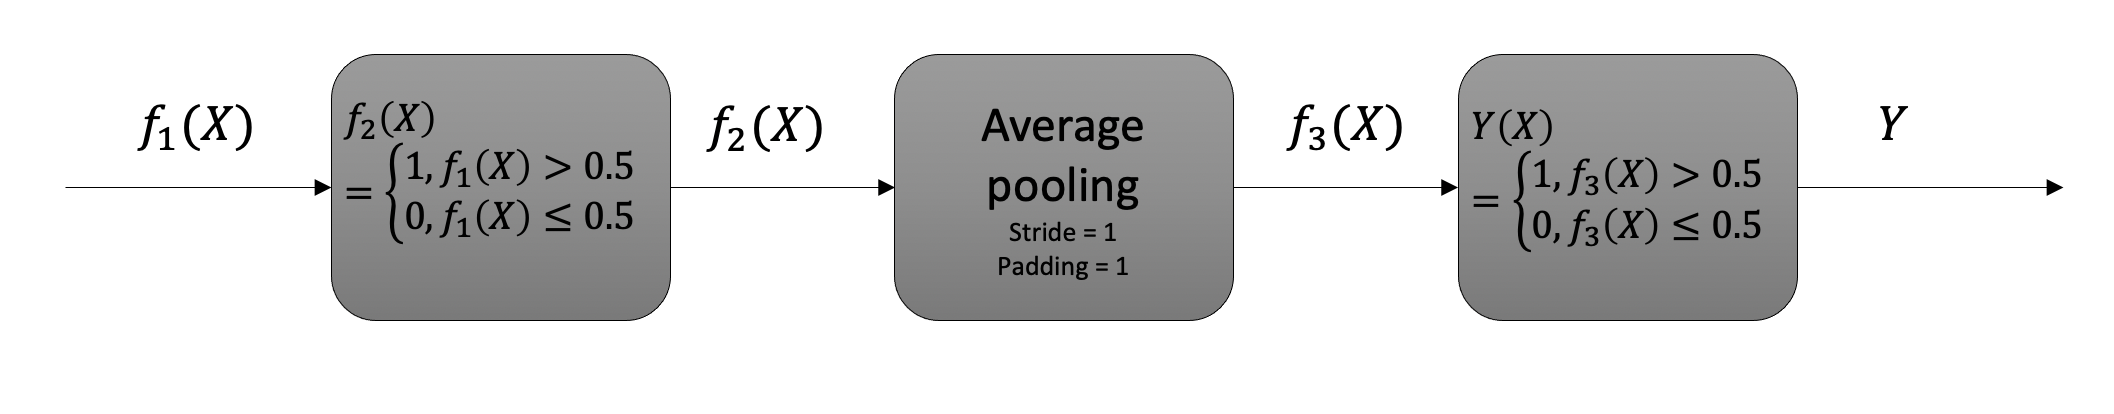

$X$ - MRI brain image 

$f_1(X)$ - the output image of the DNN model

$Y(X)$ - the output of the all model after the decision rule, "the segmantion image"  

**What is our benchmark?**

Since the segementation target isn't balanced - meaning that the tumor zone isn't 50% of the image, we need to find a better benchmark than just accuracy of each image.

We are using confusion matrix in order to track our performance.
Out main interest are positive values and negative values and their detection status (i.e. true for right answer and false for negative answer).

Positive values are tumor areas. We want to maximize true positive values which means that the model's detected parts are classified correctly.

Negative value are non-tomur areas. We want to maximize the true negative values which means that the model's non-detected parts are classified correctly.

We wish to avoid false negative values - false negative values are tumor areas that has been detected as non-tomur, which means we missed our target in general!
In contrast, false positive values are less cricitcal for us, because we rather take the chance that a non-tumor detected as a tumor.

Our main focus from now on is about the true-positive and true-negative values which we wish to maximize. Note that we care more about the true-negative to be as close to 100% accuracy, because we will get that false-negative will be close to 0% accuracy, and this is important for us, as we mentioned before.

In [300]:
def plot_learning_curve_segment(iters_train, train_losses, train_tp, train_tn, iters_valid, valid_losses, valid_tp, valid_tn):
    """
    Plot the learning curve.
    """
    d = iters_train // iters_valid

    plt.title("Learning Curve: Loss per Iteration")
    plt.plot(range(iters_train), train_losses, label="Train")
    plt.plot(range(d, iters_train+1, d), valid_losses, label="Valid")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.grid()
    plt.show()

    plt.title("Learning Curve: True-Positive")
    plt.plot(range(iters_train), train_tp, label="Train True-Positive")
    plt.plot(range(d, iters_train+1, d), valid_tp, label="Valid True-Positive")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.legend(loc='best')
    plt.show()

    plt.title("Learning Curve: True-Negative")
    plt.plot(range(iters_train), train_tn, label="Train True-Negative")
    plt.plot(range(d, iters_train+1, d), valid_tn, label="Valid True-Negative")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.legend(loc='best')
    plt.show()

In [ ]:
#run of the model with the best hyperparameter
p = 0.
lr = 0.005
wd = 5e-06

model_seg = SegNet()
model_seg = model_seg.cuda()
#print(Model)
print('#######################################')
print('   p = {:.2} | lr = {} | wd = {}   '.format(p,lr,wd))
print('#######################################')
train_info = train_gen(model=model_seg,
                    num_epochs=50, 
                    batch_size=32, 
                    learning_rate=lr, 
                    weight_decay=wd, train_x=train_x, train_y_label=train_y_mask)

#######################################
   p = 0.0 | lr = 0.005 | wd = 5e-06   
#######################################
Epoch:1, 	Train Loss:0.0400, True-Positive:0.2852, True-Negative:0.9668 
		Valid Loss:0.0253, True-Positive:0.5637, True-Negative:0.9594

Epoch:2, 	Train Loss:0.0278, True-Positive:0.5962, True-Negative:0.9626 
		Valid Loss:0.0220, True-Positive:0.7218, True-Negative:0.9545

Epoch:3, 	Train Loss:0.0235, True-Positive:0.7023, True-Negative:0.9676 
		Valid Loss:0.0191, True-Positive:0.7610, True-Negative:0.9692

Epoch:4, 	Train Loss:0.0204, True-Positive:0.7706, True-Negative:0.9721 
		Valid Loss:0.0175, True-Positive:0.8180, True-Negative:0.9702

Epoch:5, 	Train Loss:0.0178, True-Positive:0.8213, True-Negative:0.9762 
		Valid Loss:0.0178, True-Positive:0.7832, True-Negative:0.9754

Epoch:6, 	Train Loss:0.0163, True-Positive:0.8458, True-Negative:0.9787 
		Valid Loss:0.0187, True-Positive:0.7617, True-Negative:0.9741

Epoch:7, 	Train Loss:0.0155, True-Positive:0.8570, T


#############################################
#         training curves                   #
#############################################



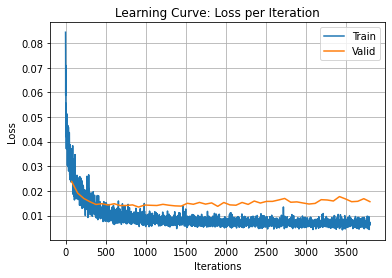

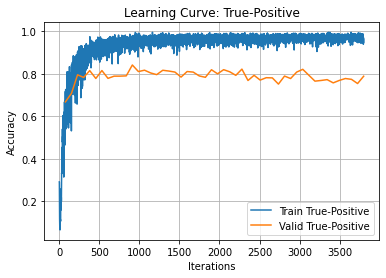

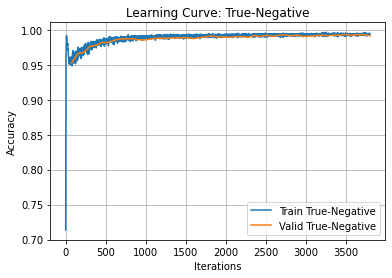

In [ ]:
print('\n#############################################')
print('#         training curves                   #')
print('#############################################\n')

plot_learning_curve_segment(*train_info)

In [301]:
def estimate_segment_accuracy(model, data_x, data_y, batch_size=32):
    """
    Estimate the accuracy of the model on the data - for true positive and true negative
    """
    acc_tp = 0
    acc_tn = 0

    N = 0
    for i in range(0, data_x.shape[0], batch_size):
        # get a batch of data
        x = data_x[i:(i + batch_size)]
        y_mask = data_y[i:(i + batch_size)]
        # forward pass prediction
        with torch.no_grad():
            out = model(x.cuda())
        
        tp, tn = acc_tpn(out, y_mask)
        acc_tp += tp
        acc_tn += tn

        N += 1
    
    return np.float(acc_tp)/N, np.float(acc_tn)/N


In [302]:
#save or load the model 

path='/content/gdrive/My Drive/Colab Notebooks/DNN-Intro-Final/model/segmentation.pt' 

# #save model

#torch.save(model_seg, path) 

#load model
model_seg = torch.load(path).cuda()


#testing the model performence

model_seg.eval()

test_acc = estimate_segment_accuracy(model_seg, train_x, train_y_mask, batch_size=100)
print("Train - True-Positive:{:.2%}, True-Negative:{:.2%}.".format(*test_acc))

Train - True-Positive:98.23%, True-Negative:99.42%.


## Test Accuracy Check

In [303]:
test_acc = estimate_segment_accuracy(model_seg, test_x, test_y_mask, batch_size=30)
print("Test set accuracy - True-Positive:{:.2%}, True-Negative:{:.2%}.".format(*test_acc))

Test set accuracy - True-Positive:75.68%, True-Negative:99.42%.


The true-positive and true-negative results are good. We wanted to get high accuracy at true-negative because every slight error will be noticed, since the negative values are almost 90% of every image. The percentage of accuracy for true-positive is good although it’s around 80%~ because the positive values are at worst 20% of the whole image.

## Segmentation Examples -

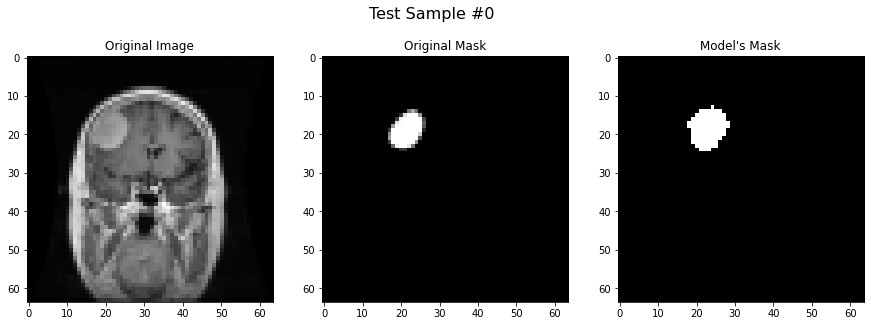

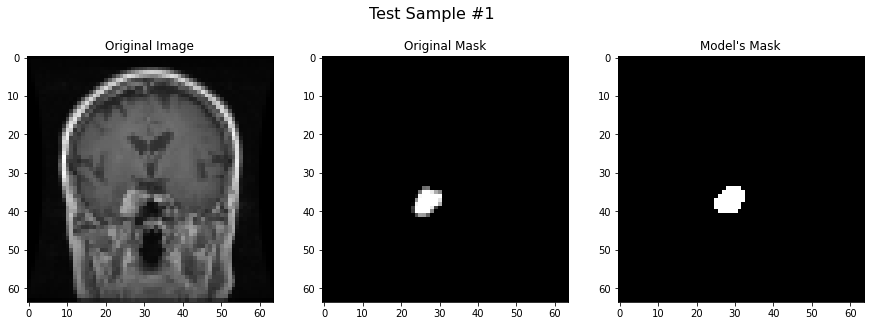

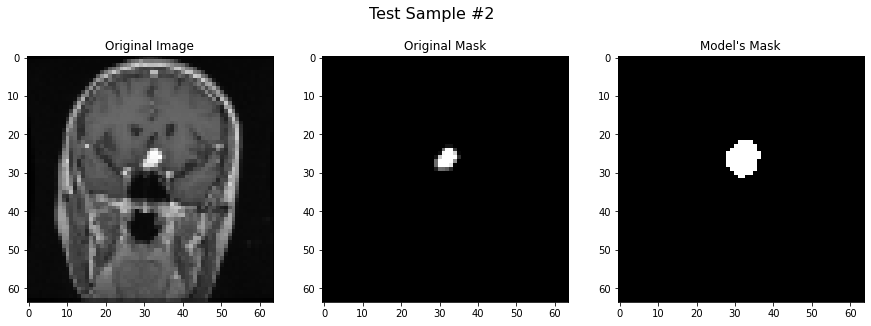

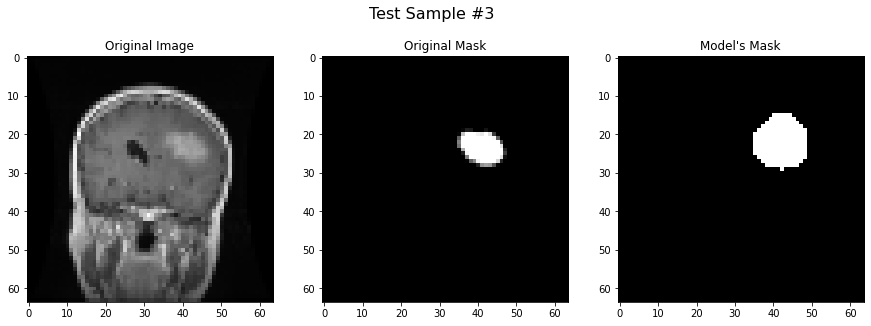

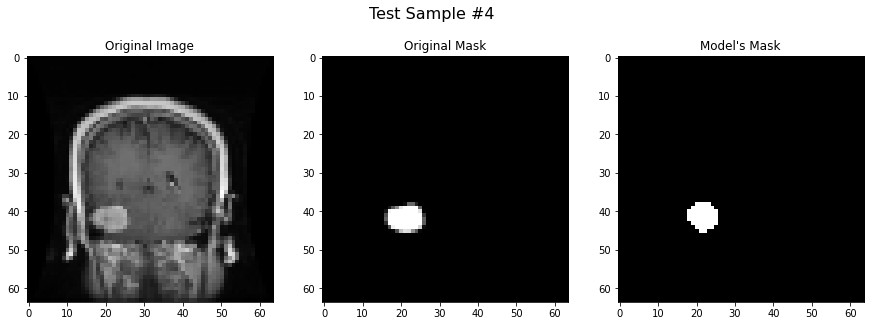

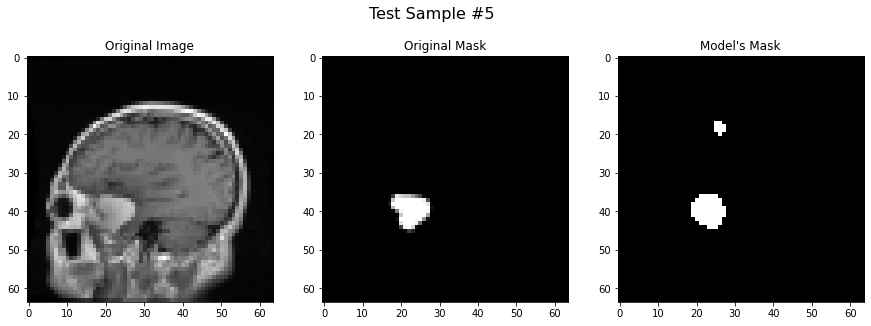

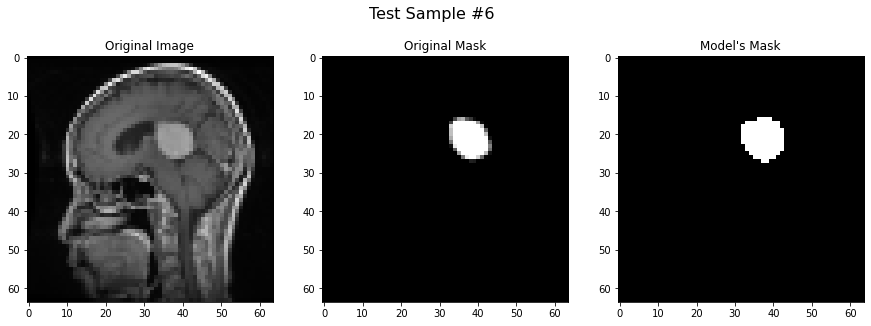

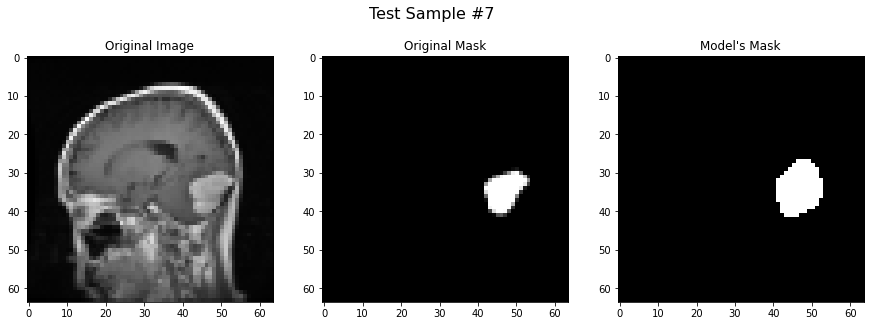

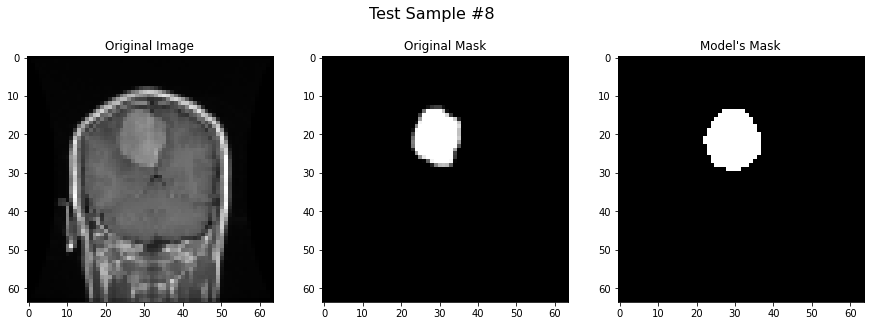

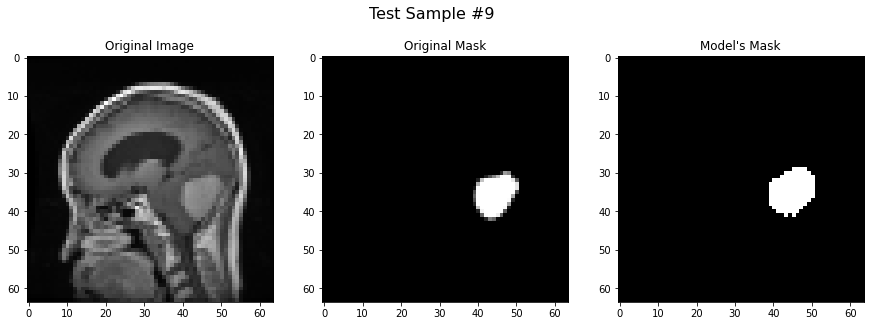

In [304]:
for i in range(10):
    out = model_seg(test_x[i:i+1].cuda())
    out = out.detach()[0]
    out = out_pred(out).cpu().numpy()[0]
    out = (out > 0.5).astype(int)
    target = test_y_mask[i]

    fig, ax = plt.subplots(1, 3, figsize=(15,5))
    fig.suptitle(f'Test Sample #{i}', fontsize=16)
    ax[0].imshow(test_x[i,0], cmap='gray')
    ax[0].set_title(f"Original Image")
    ax[1].imshow(test_y_mask[i], cmap='gray')
    ax[1].set_title(f"Original Mask")
    ax[2].imshow(out, cmap='gray')
    ax[2].set_title(f"Model's Mask")
    plt.show()


We can see that the segmentation network detecting sometimes parts in the MRI scan, that aren’t a tumor, but in addition to no tumor areas, the tumor is detected in some deviation from the exact border of the tumor.

#Hybrid Model - Classification with Segmentation

Now we try to improve the classification model by aiding the model with the previous sementation network.

**The input of the model:** matrix with size 2x64x64 where the first channel is MRI brain image - gray scale image with size of 64x64
and the second channel is the segmantation of the image that we get from the previous model.

**The output of the model:** one value from the set {0,1,2} which represents the tumor class of the image. 


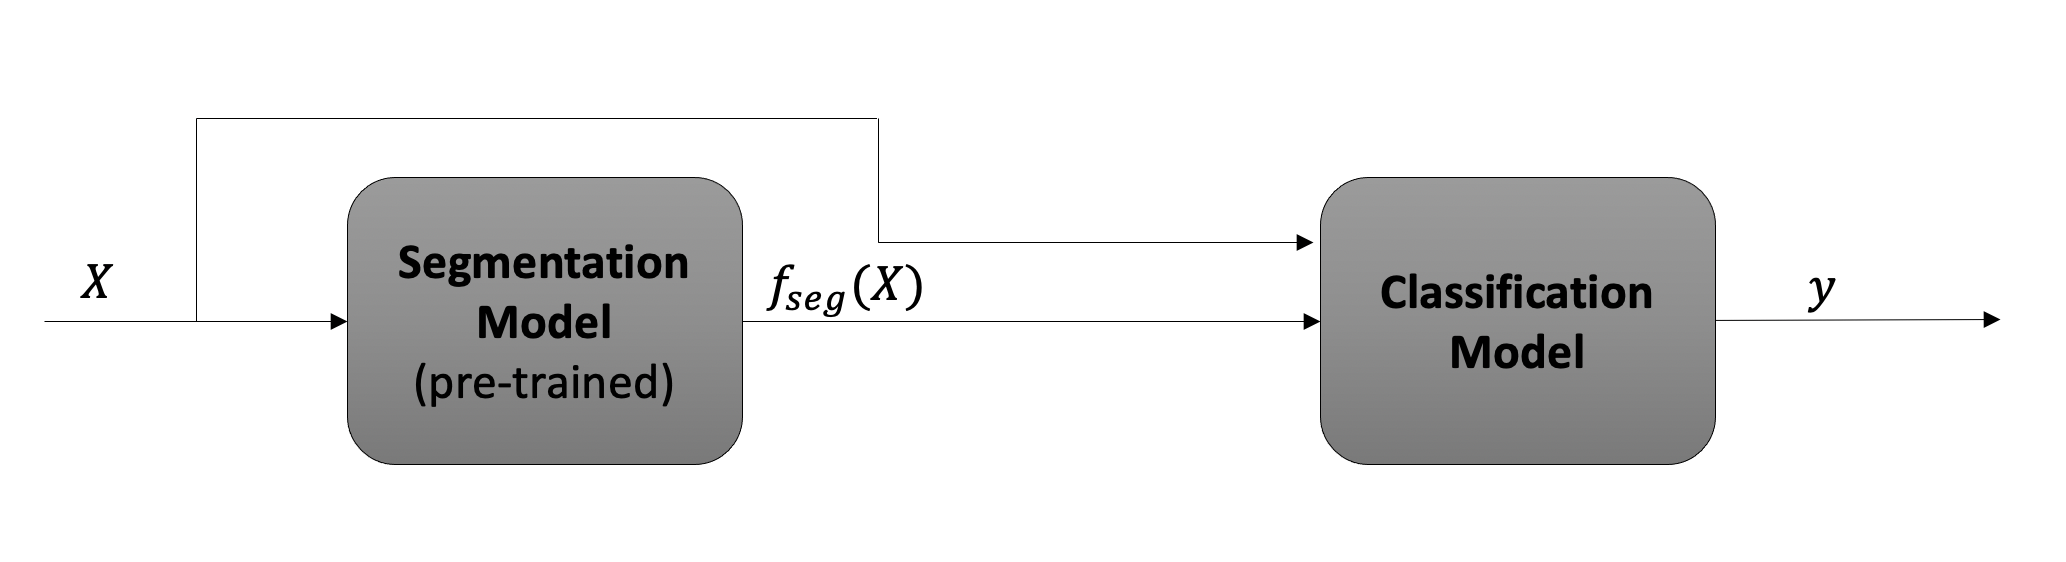

$X$ - MRI brain image with size 1x64x64 (grayscale)

$f_seg(X)$ - the segmentation image of $X$ with size 1x64x64, from the segmentation model(that pre-trained) 

$y$ - the esstimation label of the input $X$ 

##Training Loop Creation

In [305]:
def train_hybrid(model, model_seg, num_epochs=5, batch_size=64, learning_rate=1e-3, weight_decay=1e-5):
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []
    iters_train = 0
    iters_valid = 0


    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    model_seg.eval()

    for epoch in range(num_epochs):
        tr_x, tr_y_label, tr_y_mask = shuffle_data(train_x_700_img, train_y_label_700_img, train_y_mask_700_img)   # shuffle the data before train
        epoch_loss = []
        epoch_acc = []
        for i in range(0, len(tr_x), batch_size):                                          # iterate over each minibatch
            # minibatch that we are working with:
            x = tr_x[i:(i + batch_size)]
            y_label = tr_y_label[i:(i + batch_size)].cuda()
            y_mask = tr_y_mask[i:(i + batch_size)]
            # since len(train_x) does not divide batch_size evenly, we will skip over
            # the "last" minibatch
            if np.shape(x)[0] != batch_size:
                continue

            x=x.cuda()
            x_seg = model_seg(x) #create the segmentation of the MRI brain image by the previous model 
            x = torch.cat((x, x_seg), dim=1)
            optimizer.zero_grad()
            model_out = model(x)
            loss = criterion(model_out, y_label.type(torch.cuda.LongTensor))

            iters_train += 1
            epoch_loss.append(loss)                                                         # train loss append
            probs = torch.softmax(model_out, dim=-1)

            ans = probs.argmax(dim=-1)
            epoch_acc.append(torch.sum( probs.argmax(dim=-1) == y_label) / batch_size)        # train accuracy append
            loss.backward()
            optimizer.step()

        # validation check:
        iters_valid += 1
        with torch.no_grad():
            valid_x_hybrid = valid_x_700_img.cuda()
            x_seg = model_seg(valid_x_hybrid) #create the segmentation of the MRI brain image by the previous model 
            valid_x_hybrid = torch.cat((valid_x_hybrid, x_seg), dim=1)
            model_out = model(valid_x_hybrid)
        valid_losses.append(criterion(model_out, valid_y_label_700_img.type(torch.cuda.LongTensor)))
        probs = torch.softmax(model_out, dim=-1).cpu()
        valid_accuracies.append(torch.sum( probs.argmax(dim=-1) == valid_y_label_700_img ) / len(valid_x_700_img))

        train_losses.extend(epoch_loss)
        train_accuracies.extend(epoch_acc)

        epoch_loss = torch.FloatTensor(epoch_loss)
        epoch_acc = torch.FloatTensor(epoch_acc)
        print('Epoch:{}, Mean Train Loss:{:.4f}, Mean Train Accuracy:{:.4f}, '\
              'Valid Loss:{:.4f}, Valid Accuracy:{:.4f}'  \
              .format(epoch+1, torch.mean(epoch_loss), torch.mean(epoch_acc), valid_losses[-1], valid_accuracies[-1]))
    return iters_train, train_losses, train_accuracies, iters_valid, valid_losses, valid_accuracies


##Running the Model

### Training the Model

Model creation, training and plotting results for train and validation set.

In the following section we will search for the optimal hyperparameters - rate of dropout, weight decay value (L2 regularization) and learning rate.

We want to take the best model in terms of validation accuracy.

In [309]:
#save or load the model 

path='/content/gdrive/My Drive/Colab Notebooks/DNN-Intro-Final/model/segmentation.pt' 

#load model
model_seg = torch.load(path).cuda()

#run of the model with the best hyperparameter
p = 0.
lr = 0.0019
wd = 1e-05

model_hybrid=Model(p=p, in_channels=2).cuda()
#print(Model)
print('#######################################')
print('   p = {:.2} | lr = {} | wd = {}   '.format(p,lr,wd))
print('#######################################')
train_info = train_hybrid(model=model_hybrid, model_seg=model_seg,
                    num_epochs=40, 
                    batch_size=64, 
                    learning_rate=lr, 
                    weight_decay=wd)

#######################################
   p = 0.0 | lr = 0.0019 | wd = 1e-05   
#######################################
Epoch:1, Mean Train Loss:0.7219, Mean Train Accuracy:0.6983, Valid Loss:0.5658, Valid Accuracy:0.7714
Epoch:2, Mean Train Loss:0.4724, Mean Train Accuracy:0.8245, Valid Loss:0.4467, Valid Accuracy:0.8190
Epoch:3, Mean Train Loss:0.3461, Mean Train Accuracy:0.8918, Valid Loss:0.3736, Valid Accuracy:0.8762
Epoch:4, Mean Train Loss:0.2697, Mean Train Accuracy:0.9207, Valid Loss:0.3285, Valid Accuracy:0.8905
Epoch:5, Mean Train Loss:0.2179, Mean Train Accuracy:0.9393, Valid Loss:0.3243, Valid Accuracy:0.8619
Epoch:6, Mean Train Loss:0.1640, Mean Train Accuracy:0.9639, Valid Loss:0.2574, Valid Accuracy:0.9238
Epoch:7, Mean Train Loss:0.1444, Mean Train Accuracy:0.9651, Valid Loss:0.2670, Valid Accuracy:0.9000
Epoch:8, Mean Train Loss:0.1220, Mean Train Accuracy:0.9718, Valid Loss:0.2755, Valid Accuracy:0.8952
Epoch:9, Mean Train Loss:0.0958, Mean Train Accuracy:0.9814, Va


#############################################
#         training curves                   #
#############################################



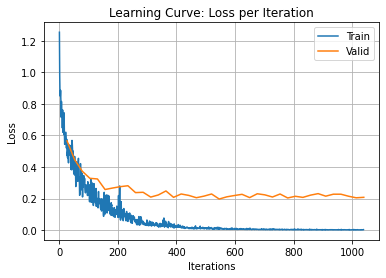

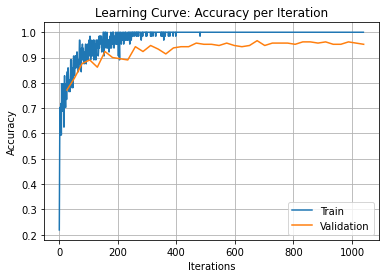

In [310]:
print('\n#############################################')
print('#         training curves                   #')
print('#############################################\n')
plot_learning_curve(*train_info)

**The training and validation accuracies:** 

**From the paper:**  98.51% and 84.19% , respectively

**Our first result(classification model):** 100% and 91.43% , respectively

**Our first result(hybrid model):** 100% and 95.24% , respectively


The training set is almost identical in the accuracy percentages. In addition, the validation set has better accuracy with the hybrid model, than classification model and the paper, i.e. we reduced the generalization error of the model.

### Test Accuracy Check

In [311]:
def estimate_hybrid_accuracy(model, model_seg, data_x, data_y, batch_size=5000):
    """
    Estimate the accuracy of the model on the data.
    """
    correct = 0
    N = 0
    for i in range(0, data_x.shape[0], batch_size):
        # get a batch of data
        x = data_x[i:(i + batch_size)]
        y_label = data_y[i:(i + batch_size)]
        x=x.cuda()
        x_seg = model_seg(x) #create the segmentation of the MRI brain image by the previous model 
        x = torch.cat((x, x_seg), dim=1)
        # forward pass prediction
        with torch.no_grad():
            out = model(x)
        pred = torch.argmax(out, axis=-1).cpu()
        correct += torch.sum(pred == y_label)
        N += data_x.shape[0]
    
    return np.float(correct / N)


Evaluating the test set accuracy,

In [312]:
test_acc = estimate_hybrid_accuracy(model_hybrid, model_seg, test_x_700_img, test_y_label_700_img, batch_size=2000)
print("Test set accuracy: {:.2%}".format(float(test_acc)))

Test set accuracy: 94.76%


As we can see, the test accuracy is pretty much alike the validation, thus we can conclude that our model learned well the data.

**Our first result(classification model):** 90.48%%

**Our first result(hybrid model):** 94.76%

The test set has better accuracy with the hybrid model, than classification model, i.e. we reduced the generalization error of the model.

# Conclusions

After matching the classification network mentioned in the paper, we can see that a simple CNN and hyper parameters sweep can achieve better results. In addition regularization might help the generalization, as well as we used it in our first model.

Segmentation network worked well with a Segnet architecture. The loss function we picked was very critical to achieve right accuracy. We can infer that unbalanced class is a hard classification problem, but can be solved using weighted measures.

In the end, our hybrid model proved to contribute to classification. Both the validation set and test set had better accuracy. In the hybrid model, the input to the classification block image consists of two channels: the first channel is the MRI image, and the second is the segmentation ("mask") of the tumor. The concept is that the mask of the tumor helps the network to focus on the precise area of the tumor in the MRI images.

# References

[1] Abiwinanda, Nyoman, et al. "Brain tumor classification using convolutional  neural network." World congress on medical physics and biomedical engineering 2018. Springer, Singapore, 2019.‏


[2] Lundberg, Scott M., and Su-In Lee. "A unified approach to interpreting model predictions." Proceedings of the 31st international conference on neural information processing systems. 2017.‏

[3] "SHAP Values Explained Exactly How You Wished Someone Explained to You", Towards Data Science https://towardsdatascience.com/shap-explained-the-way-i-wish-someone-explained-it-to-me-ab81cc69ef30 .

[4] Badrinarayanan, Vijay, Alex Kendall, and Roberto Cipolla. "Segnet: A deep convolutional encoder-decoder architecture for image segmentation." IEEE transactions on pattern analysis and machine intelligence 39.12 (2017): 2481-2495.‏
